# The Golden Gloves
Data Source - https://www.seanlahman.com/baseball-archive/statistics/  

# Summary

#### Why Random Forest?
It proved to be the model that most accurately predicted inductee status without blanket predicting nobody was inducted.  

#### Preprocessing:
Before learning with the data, we dropped columns that contained inconsitent data. In addition, we dropped all HOF nominees who were not players. Finally, we built a pipeline that uses SMOAT to oversample the data - This is done to enable the model to have more training data to learn trends in the rare occurence someone is inducted into the HOF.  

#### Lessons Learned:
* Originally we tried using Logistic Regression, however this ended up being extremely inaccurate - with an accuracy score of 12% once it was properly working. Very low accuracy and recall values.
* After this we attempted to use a deep neural network. This model was immediately more accurate, however upon further investigation we found this was only due to it predicting that nobody was inducted to the HOF. It could not predict the rare circumstance. High accuracy and bad recall.
* Next was our first iteration of Random Forest Classification, the model was fairly accurate from the start, but didn't make sense when dug into further. The reason behind this was we were feeding in too many columns of data, as we had combined our batting, fielding, and pitching tables all into one. This doesn't work, as players can be inducted soley on one of these tables, and be average on the others.
* Finally we seperated our datasets again and ran the Random Forest Model on all of them independantly. This resulted in both the confusion matrixes and feature importances of the predictions looking significantly better. This finally resulsted in precision, recall, and accuracy being greater then 90%.


In [32]:
# Importing necessary packages
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pandas setup
pd.set_option('display.max_columns', None)

# Hall of Fame Data
Providing example of how two tables could be combined to create a more readble hall of fame table.

In [33]:
# Importing data
hall_of_fame_df = pd.read_csv("Resources/baseballdatabank-master/core/HallOfFame.csv")
hall_of_fame_df.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN


# Career Batting Data
Providing a general exmaple of how batting data could be used.

In [34]:
# Importing data
batting_df = pd.read_csv("Resources/baseballdatabank-master/core/batting.csv")
batting_df.drop(columns=['yearID', 'teamID', 'IBB', 'HBP', 'SH', 'SF', 'stint', 'lgID'], inplace=True)
batting_df.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,GIDP
0,abercda01,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0
1,addybo01,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,0.0
2,allisar01,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,1.0
3,allisdo01,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,0.0
4,ansonca01,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,0.0


In [35]:
# Grouping by playerID and yearID, then sorting by home runs by season
career_batting_df = batting_df.groupby(['playerID']).sum()

In [36]:
# Adding batting prefix to every column to ensure there aren't conflicts when combined with fielding and pitching
career_batting_df = career_batting_df.add_prefix('b_')

# Career Fielding Data

In [37]:
# Importing data
fielding_df = pd.read_csv("Resources/baseballdatabank-master/core/Fielding.csv")

# Dropping inconsistent columns
fielding_df.drop(['lgID', 'PB', 'WP', 'SB', 'CS', 'ZR'], axis=1, inplace=True)

# Dropping unnecessary columns
fielding_df.drop(['yearID', 'stint', 'teamID', 'POS'], axis=1, inplace=True)

# Grouping by playerID to get career stats
career_fielding_df = fielding_df.groupby(['playerID']).sum()

# Adding batting prefix to every column to ensure there aren't conflicts when combined with batting and pitching
career_fielding_df = career_fielding_df.add_prefix('f_')
career_fielding_df.head()


,f_G,f_GS,f_InnOuts,f_PO,f_A,f_E,f_DP
playerID,,,,,,,
aardsda01,331,0.0,1011.0,11,29,3.0,2
aaronha01,3020,2977.0,78414.0,7436,429,144.0,218
aaronto01,387,206.0,6472.0,1317,113,22.0,124
aasedo01,448,91.0,3328.0,67,135,13.0,10
abadan01,9,4.0,138.0,37,1,1.0,3


# Career Pitching Data

In [38]:
# Importing data
pitching_df = pd.read_csv("Resources/baseballdatabank-master/core/Pitching.csv")

# Dropping inconsistent columns
pitching_df.drop(['lgID', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'BAOpp'], axis=1, inplace=True)

# Dropping unnecessary columns
pitching_df.drop(['yearID', 'stint', 'teamID'], axis=1, inplace=True)

# Grouping by playerID to get career stats
career_pitching_df = pitching_df.groupby(['playerID']).sum()

# Adding batting prefix to every column to ensure there aren't conflicts when combined with batting and pitching
career_pitching_df = career_pitching_df.add_prefix('p_')

career_pitching_df.head()

,p_W,p_L,p_G,p_GS,p_CG,p_SHO,p_SV,p_IPouts,p_H,p_ER,p_HR,p_BB,p_SO,p_ERA,p_WP,p_BK,p_BFP,p_GF,p_R
playerID,,,,,,,,,,,,,,,,,,,
aardsda01,16,18,331,0,0,0,69,1011,296,160,41,183,340,46.75,12,1,1475.0,141,169
aasedo01,66,60,448,91,22,5,82,3328,1085,468,89,457,641,45.41,22,3,4730.0,235,503
abadfe01,8,29,384,6,0,0,2,992,309,135,42,116,280,40.81,10,2,1399.0,97,143
abbeybe01,22,40,79,65,52,0,1,1704,686,285,18,192,161,28.07,18,0,2568.0,14,442
abbeych01,0,0,1,0,0,0,0,6,6,1,0,0,0,4.50,1,0,12.0,1,3


# Exporting Custom Datasets to CSV files

In [39]:
# Exporting career batting dataframe to csv
career_batting_df.to_csv('Resources/custom-tables/career-batting.csv')

# Exporting career fielding dataframe to csv
career_fielding_df.to_csv('Resources/custom-tables/career-fielding.csv')

# Exporting career pitching dataframe to csv
career_pitching_df.to_csv('Resources/custom-tables/career-pitching.csv')

# RFC Career Batting Data

In [40]:
batting_ml_df = pd.merge(hall_of_fame_df, career_batting_df, left_on='playerID', right_on='playerID')
batting_ml_df = batting_ml_df[batting_ml_df['category'] == 'Player']
batting_ml_df.drop(['playerID','yearID', 'votedBy', 'ballots', 'needed', 'votes', 'category', 'needed_note'], axis=1, inplace=True)
batting_ml_df.head()

,inducted,b_G,b_AB,b_R,b_H,b_2B,b_3B,b_HR,b_RBI,b_SB,b_CS,b_BB,b_SO,b_GIDP
0,Y,3035,11436,2247,4189,724,295,117,1944.0,896.0,178.0,1249,608.0,0.0
1,Y,2503,8398,2174,2873,506,136,714,2217.0,123.0,117.0,2062,1330.0,2.0
2,Y,2794,10439,1739,3420,643,252,101,1733.0,723.0,15.0,963,735.0,0.0
3,N,2794,10439,1739,3420,643,252,101,1733.0,723.0,15.0,963,735.0,0.0
4,Y,647,1687,151,362,50,12,7,165.0,20.0,1.0,116,218.0,0.0


In [41]:
# Defining oversampling method
smote = SMOTE(sampling_strategy='not majority')

# Defining learning method
rfc = RandomForestClassifier(
    max_depth=25,
    n_estimators = 5000,
    random_state=0)

# Define the learning pipeline
clf = Pipeline(steps=[('sampling', smote), ('classifier', rfc)])

# assigning data
y = batting_ml_df[['inducted']].values
X = batting_ml_df.drop(['inducted'], axis=1)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

Pipeline(steps=[('sampling', SMOTE(sampling_strategy='not majority')),
                ('classifier',
                 RandomForestClassifier(max_depth=25, n_estimators=5000,
                                        random_state=0))])

In [42]:
# Getting accuracy of model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.948019801980198


In [43]:
# Creating confusion matrix
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)
cm

array([[754,   9],
       [ 33,  12]], dtype=int64)

In [44]:
# Printing summary of model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           N       0.96      0.99      0.97       763
           Y       0.57      0.27      0.36        45

    accuracy                           0.95       808
   macro avg       0.76      0.63      0.67       808
weighted avg       0.94      0.95      0.94       808



# Visiualizing the Batting Prediction Model

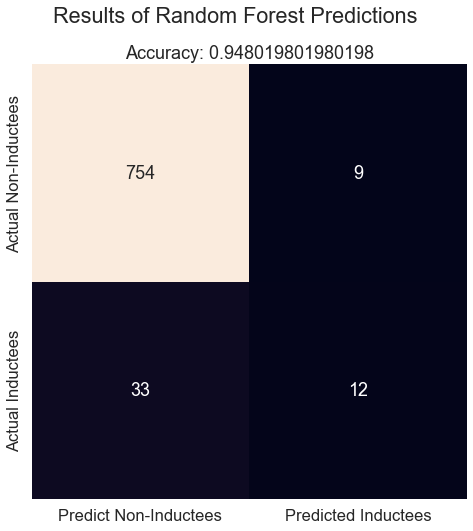

In [45]:
# Increasing plot size
sns.set(rc = {'figure.figsize': (15,8)})

# Increasing default text size
sns.set(font_scale=1.5)

# Creating heatmap
sns.heatmap(
    cm,             # data given to map
    annot=True,     # annotating numbers to squares
    square=True,    # making all sectors equal squares
    xticklabels=['Predict Non-Inductees', 'Predicted Inductees'],
    yticklabels=['Actual Non-Inductees', 'Actual Inductees'],
    cbar=False,     # disabling color bar
    fmt='g'         # forcing standard number notation
)

# Adding title to plot
plt.suptitle('Results of Random Forest Predictions')
plt.title(f'Accuracy: {accuracy}')

# Displaying plot
plt.show()

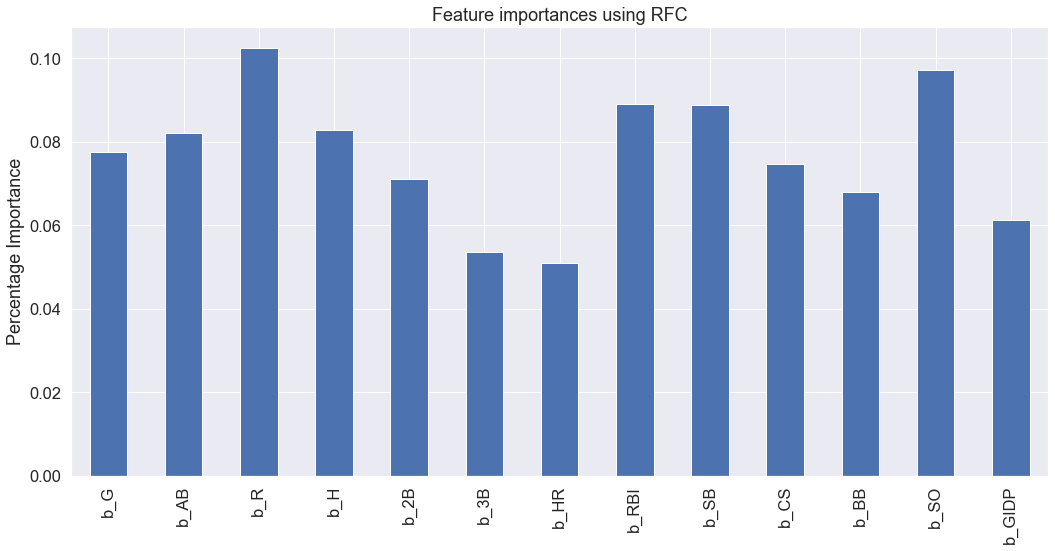

In [46]:
# Displaying feature importances
importances = clf[1].feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using RFC")
ax.set_ylabel("Percentage Importance")
fig.tight_layout()

# RFC of Career Pitching Stats

In [47]:
pitching_ml_df = pd.merge(hall_of_fame_df, career_pitching_df, left_on='playerID', right_on='playerID')
pitching_ml_df = pitching_ml_df[pitching_ml_df['category'] == 'Player']
pitching_ml_df.drop(['playerID','yearID', 'votedBy', 'ballots', 'needed', 'votes', 'category', 'needed_note'], axis=1, inplace=True)
pitching_ml_df.head()

,inducted,p_W,p_L,p_G,p_GS,p_CG,p_SHO,p_SV,p_IPouts,p_H,p_ER,p_HR,p_BB,p_SO,p_ERA,p_WP,p_BK,p_BFP,p_GF,p_R
0,Y,0,0,3,0,0,0,1,15,6,2,0,2,0,4.50,0,0,20.0,2,2
1,Y,94,46,163,148,107,17,4,3664,974,309,10,441,488,36.80,25,4,5006.0,11,398
2,Y,0,0,2,0,0,0,0,25,7,0,0,6,6,0.00,3,0,37.0,2,5
3,N,0,0,2,0,0,0,0,25,7,0,0,6,6,0.00,3,0,37.0,2,5
4,Y,373,188,636,552,435,79,29,14366,4219,1135,90,848,2507,47.69,115,8,18943.0,73,1620


In [48]:
# Defining oversampling method
smote = SMOTE(sampling_strategy='not majority')

# Defining learning method
rfc = RandomForestClassifier(
    max_depth=25,
    n_estimators = 5000,
    random_state=0)

# Define the learning pipeline
clf = Pipeline(steps=[('sampling', smote), ('classifier', rfc)])

# assigning data
y = pitching_ml_df[['inducted']].values
X = pitching_ml_df.drop(['inducted'], axis=1)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

Pipeline(steps=[('sampling', SMOTE(sampling_strategy='not majority')),
                ('classifier',
                 RandomForestClassifier(max_depth=25, n_estimators=5000,
                                        random_state=0))])

In [49]:
# Getting accuracy of model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.91875


In [50]:
# Creating confusion matrix
from sklearn.metrics import confusion_matrix

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)
cm

array([[288,  11],
       [ 15,   6]], dtype=int64)

In [51]:
# Printing summary of model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           N       0.95      0.96      0.96       299
           Y       0.35      0.29      0.32        21

    accuracy                           0.92       320
   macro avg       0.65      0.62      0.64       320
weighted avg       0.91      0.92      0.91       320



# Visiualizing Pitching Prediction Model

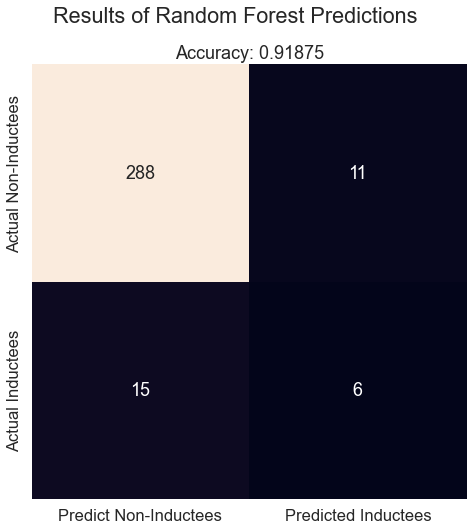

In [52]:
# Increasing plot size
sns.set(rc = {'figure.figsize': (15,8)})

# Increasing default text size
sns.set(font_scale=1.5)

# Creating heatmap
sns.heatmap(
    cm,             # data given to map
    annot=True,     # annotating numbers to squares
    square=True,    # making all sectors equal squares
    xticklabels=['Predict Non-Inductees', 'Predicted Inductees'],
    yticklabels=['Actual Non-Inductees', 'Actual Inductees'],
    cbar=False,     # disabling color bar
    fmt='g'         # forcing standard number notation
)

# Adding title to plot
plt.suptitle('Results of Random Forest Predictions')
plt.title(f'Accuracy: {accuracy}')

# Displaying plot
plt.show()

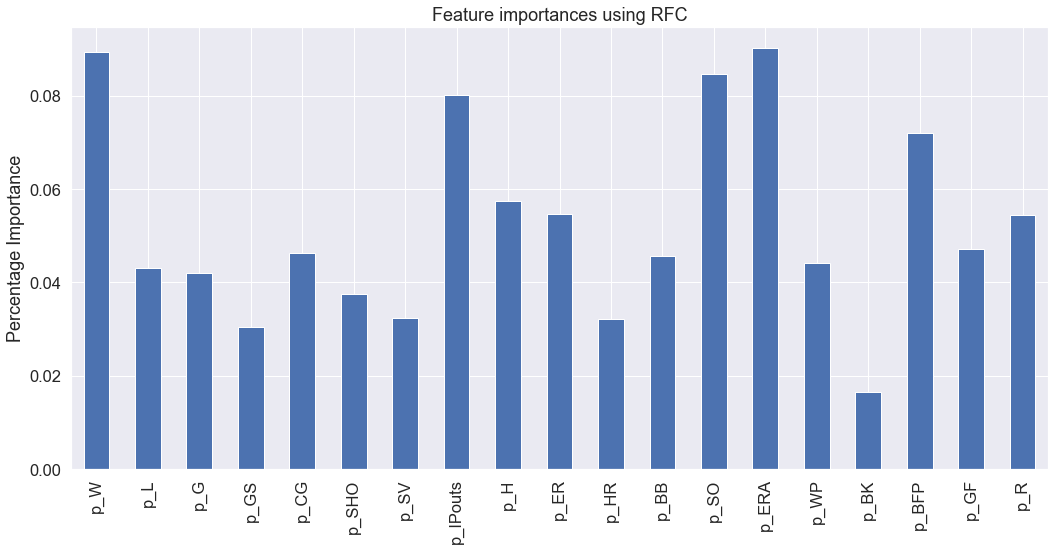

In [53]:
# Displaying feature importances
importances = clf[1].feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using RFC")
ax.set_ylabel("Percentage Importance")
fig.tight_layout()

# RFC of Career Fielding Data

In [54]:
fielding_ml_df = pd.merge(hall_of_fame_df, career_fielding_df, left_on='playerID', right_on='playerID')
fielding_ml_df = fielding_ml_df[fielding_ml_df['category'] == 'Player']
fielding_ml_df.drop(['playerID','yearID', 'votedBy', 'ballots', 'needed', 'votes', 'category', 'needed_note'], axis=1, inplace=True)
fielding_ml_df.head()

,inducted,f_G,f_GS,f_InnOuts,f_PO,f_A,f_E,f_DP
0,Y,2954,725.0,19266.0,6507,410,278.0,113
1,Y,2436,0.0,0.0,4787,569,179.0,86
2,Y,2777,997.0,50064.0,7940,6782,828.0,963
3,N,2777,997.0,50064.0,7940,6782,828.0,963
4,Y,643,266.0,10032.0,313,1506,57.0,44


In [55]:
# Defining oversampling method
smote = SMOTE(sampling_strategy='not majority')

# Defining learning method
rfc = RandomForestClassifier(
    max_depth=25,
    n_estimators = 5000,
    random_state=0)

# Define the learning pipeline
clf = Pipeline(steps=[('sampling', smote), ('classifier', rfc)])

# assigning data
y = fielding_ml_df[['inducted']].values
X = fielding_ml_df.drop(['inducted'], axis=1)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

Pipeline(steps=[('sampling', SMOTE(sampling_strategy='not majority')),
                ('classifier',
                 RandomForestClassifier(max_depth=25, n_estimators=5000,
                                        random_state=0))])

In [56]:
# Getting accuracy of model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9294554455445545


In [57]:
# Creating confusion matrix
from sklearn.metrics import confusion_matrix

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)
cm

array([[743,  20],
       [ 37,   8]], dtype=int64)

In [58]:
# Printing summary of model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           N       0.95      0.97      0.96       763
           Y       0.29      0.18      0.22        45

    accuracy                           0.93       808
   macro avg       0.62      0.58      0.59       808
weighted avg       0.92      0.93      0.92       808



# Visiualzing Fielding Prediction Model

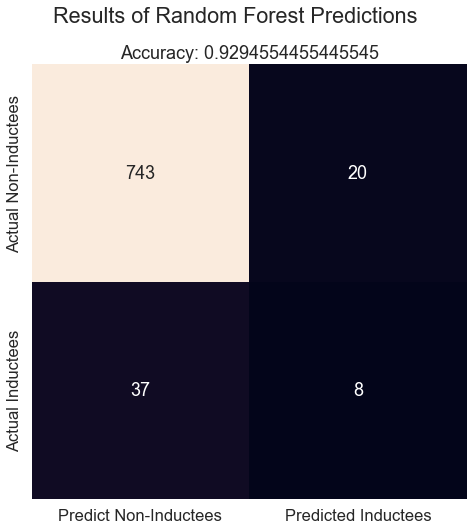

In [59]:
# Increasing plot size
sns.set(rc = {'figure.figsize': (15,8)})

# Increasing default text size
sns.set(font_scale=1.5)

# Creating heatmap
sns.heatmap(
    cm,             # data given to map
    annot=True,     # annotating numbers to squares
    square=True,    # making all sectors equal squares
    xticklabels=['Predict Non-Inductees', 'Predicted Inductees'],
    yticklabels=['Actual Non-Inductees', 'Actual Inductees'],
    cbar=False,     # disabling color bar
    fmt='g'         # forcing standard number notation
)

# Adding title to plot
plt.suptitle('Results of Random Forest Predictions')
plt.title(f'Accuracy: {accuracy}')

# Displaying plot
plt.show()

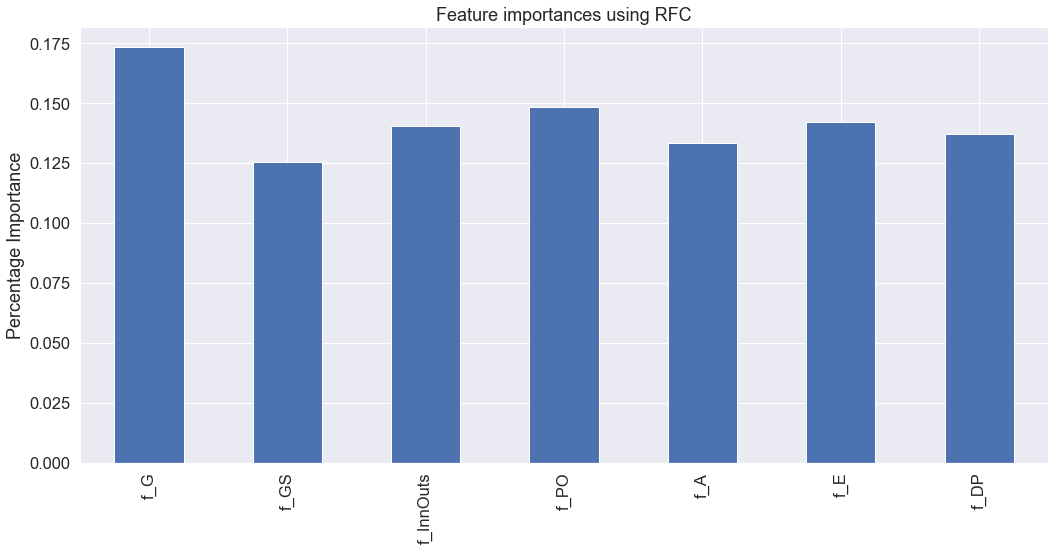

In [60]:
# Displaying feature importances
importances = clf[1].feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using RFC")
ax.set_ylabel("Percentage Importance")
fig.tight_layout()